**Search over tokenization, window, and gap sizes.**

In [54]:
import re 
import string
import timestring
from sklearn.linear_model import LinearRegression, LogisticRegression
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import cross_val_score, KFold
import glob, os
import numpy as np
from sklearn import svm
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import text
from scipy.sparse import hstack

%matplotlib inline


In [55]:
class Tokenizer:
    def __init__(self, collapse_mentions=False, collapse_digits=True):
        self.collapse_mentions = collapse_mentions
        self.collapse_digits = collapse_digits
        #self.stopwords = stopwords
        
    def tokenize(self, text):
        punc_re = '[' + '\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\_\\{\\|\\}' + ']'
        text = text.lower()
        text = re.sub('#(\S+)', r'HASHTAG_\1', text)
        if self.collapse_mentions:
            text = re.sub('@\S+', 'MENTION', text)
        else:
            text = re.sub('@\S+', 'MENTION_\1', text)
        text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        text = re.sub(r'(.)\1\1\1+', r'\1', text)
        if self.collapse_digits: # Numbers help!
            text = re.sub(r'[0-9]', '9', text) 
        toks = []
        for tok in text.split():
            tok = re.sub(r'^(' + punc_re + '+)', r'\1 ', tok)
            tok = re.sub(r'(' + punc_re + '+)$', r' \1', tok)
            for subtok in tok.split():
                if re.search('\w', subtok):
                    toks.append(subtok)
        return toks

In [56]:
DIR = '/data/2/protest'

In [57]:
def read_keywords(path):
    return [s.strip().lower() for s in open(path)]
    
keywords = read_keywords(DIR + '/keywords.txt')
keywords

['foradilma', 'fora dilma', 'forapt', 'fora pt', 'vemprarua', 'vem pra rua']

In [67]:
def print_top_terms(clf, vec, n=100):
    #feats = sorted(np.array(vec.get_feature_names()))
    #print('\n'.join(feats[np.argsort(clf.coef_[0])[::-1][:n]]))
    #print(feats[0:30])    
    coefs = sorted(zip(vec.get_feature_names(),clf.coef_[0]),key=lambda x:x[1])
    #print(coefs[0:30], '\n')
    print(coefs[-30:])

In [59]:
def read_stopwords(path):
    return [s.strip().lower() for s in open(path)]

In [30]:
import os, io, json, codecs

def matches_keywords(text, keywords):
    """ Return true if any keyword is a substring of this text, ignoring case. """
    text = text.lower()
    for kw in keywords:
        if kw in text:
            return True
    return False

def filename2user(fname):
    """Convert filename like this
      /data/2/protest/Timeline/MandinhaSimone.txt.txt
    into a username like
      MandinhaSimone
    """
    return re.sub(r'^([^\.]+)\..+', r'\1', os.path.basename(fname))

def iterate_instances(files, keywords, window_sz, gap_sz):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """
    for fname in files:
        user = filename2user(fname)
        lines = []
        #print(user)
        for i, line in enumerate(open(fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                pos_end = i+1
                neg_start = max(0, i - gap_sz - (2 * window_sz))
                neg_end = i - gap_sz - window_sz
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                yield (' '.join(lines[pos_start:pos_end]), 1, user)
                yield (' '.join(lines[neg_start:neg_end]), 0, user)
                break
            lines.append(js['text'])

In [60]:
#parse date 
def parse_date(datestring):
    from datetime import datetime

    """ Input, e.g., Mon Aug 24 19:41:14 +0000 2015
    Output, e.g., 24 """
    #Sat May 16 16:30:12 +0000 2015
    #print datestring
    parts = datestring.split()
    var = datetime.strptime(parts[1]+' ' +parts[2]+' '+ parts[5],'%b %d %Y')
    return var

In [61]:
def iterate_instances_changed(files, keywords, window_sz, gap_sz):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username, percentage of neightbors who used hashtag)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    Also we find neighbors (define as those with symetric mentions) who have also used one of the keywords 
    during positive or negative window 
    """
    DIR = '/home/elaine/Protest/protest/Brazil project/'
    DIR2='/data/2/protest/mentions/'
    dic = defaultdict(tuple)
    pkl_file = open(DIR+'all_mentions_graph.pkl', 'rb')#open pickle file where the edges of the graph is saved
    data1 = pickle.load(pkl_file)

    for _, _, f in os.walk(DIR2): f
        
    #for _, _, arquivos in os.walk(files): arquivos
        
    for fname in files:#glob.glob(path + '/*.txt'):
        
        user = filename2user(fname)
        #print('this is', user)
        lines = []
        countneg=0
        countpos=0
        #print('treino',user)
        for i, line in enumerate(open(fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #print('skipping', arquivos[fname], 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > (2*window_sz + gap_sz) and matches_keywords(js['text'], keywords):
                #yield (' '.join(lines), 1, user)
                # yield (' '.join(lines[:-negative_window]), 0, user)
                pos_start = max(0, i - window_sz)
                #print('positive window starts in',pos_start)
                pos_end = i+1
                #print('positive window finishes in',pos_end)

                #print('lineslen: ',len(lines))
                date1_pos = lines[pos_start][1]
                #print('ksdjsk',lines[pos_start][1])
                #print(pos_end)
                date2_pos = lines[pos_end-2][1]

                neg_start = max(0, i - gap_sz - (2 * window_sz))
                #print('negative window starts in',neg_start)
                neg_end = i - gap_sz - window_sz
                #print('nagative window finishes in',neg_end)
                date1_neg = lines[neg_start][1]
                date2_neg = lines[neg_end][1]

                if data1.has_node(user) == True: #if that file is in the graph
                    #print(user, 'is in the graph!')
                    neighbors = data1.neighbors(user) #get all neighbors of the user
                    #print(user, 's neighbors are: ', neighbors)
                    for n in neighbors:
                        if n +'.txt' in f:#if that file is in the directory
                            #print('vizinho: ', n)
                            neighbor = open(DIR2 + n +'.txt','r')
                            nlines = neighbor.readlines()
                            for t in reversed(nlines):
                                tweet_neighbor = json.loads(t) 
                                #print(tweet_neighbor['created_at'])
                                #print(parse_date(tweet_neighbor['created_at']) ,'>', parse_date(date1_pos) )
                                if matches_keywords(tweet_neighbor['text'],keywords):
                                    if parse_date(tweet_neighbor['created_at']) > parse_date(date1_pos) and parse_date(tweet_neighbor['created_at']) < parse_date(date2_pos):
                                        #print(n, 'posted keyword in', parse_date(tweet_neighbor['created_at']))
                                        #print('entrou!!')
                                        countpos = countpos+1
                                        break
                            for t in reversed(nlines):
                                tweet_neighbor = json.loads(t) 
                                if matches_keywords(tweet_neighbor['text'],keywords):
                                    if parse_date(tweet_neighbor['created_at']) < parse_date(date2_neg) and parse_date(tweet_neighbor['created_at']) > parse_date(date2_neg):
                                        #print(n, 'posted negkeyword in', parse_date(tweet_neighbor['created_at']))
                                        #print('1entrou!!')
                                        countneg = countneg+1
                                        break
                            dic[user]=((float(countpos)/float(len(neighbors))),float(countneg)/float(len(neighbors)))
                #print('diccc',dic)
                # print('ps=%d pe=%d ns=%d ne=%d' % (pos_start, pos_end, neg_start, neg_end))
                #print('testeee',lines[0][pos_start:pos_end])
                testepos = " ".join(l[0] for l in lines[pos_start:pos_end])
                testeneg = " ".join(l[0] for l in lines[neg_start:neg_end])
                
                yield (testepos, 1, user, float(countpos)/float(len(neighbors)))
                yield (testeneg, 0, user,float(countneg)/float(len(neighbors)))
                countneg=0
                countpos=0
                break
            lines.append((js['text'],js['created_at']))
    

In [62]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


#y_pred = model.predict(X)

def confusion_matrix(y, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm


In [71]:
def do_expt(all_files, collapse_mentions, collapse_digits, binary, ngram_range,
            min_df, use_idf, norm, window_sz, gap_sz):
    toker = Tokenizer(collapse_digits=collapse_digits, collapse_mentions=collapse_mentions)
    
    stopwords = set(read_stopwords(DIR + '/stopwords.txt'))    
    my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)
    #print('stoppp',stopwords,'\n')
    
    #print(my_stop_words)
    
    vectorizer = TfidfVectorizer(binary=binary, decode_error='ignore',ngram_range=ngram_range,
                                 max_df=1.0, min_df=min_df, use_idf=use_idf,
                                 tokenizer=toker.tokenize,
                                 norm=norm, stop_words=set(my_stop_words))
    y = []
    users = []
    neighbors=[]
    iterator = iterate_instances_changed(all_files, keywords, window_sz, gap_sz)
    X = vectorizer.fit_transform(x[0] for x in iterator if not users.append(x[2]) and not y.append(x[1]) and not neighbors.append(x[3]))
    print('X.shape=%s' % (str(X.shape)))
    X=hstack((X, np.array([neighbors]).T)).tocsr()
    y = np.array(y)
    print('X.shape=%s' % (str(X.shape)))
    cv = KFold(len(y), 10, shuffle=False)  # Don't shuffle b/c we don't want a user in both training and testing set.
    accuracies = []
    model_mod = LogisticRegression(penalty='l2', C=1)
    for train_ind, test_ind in cv:
        model_mod.fit(X[train_ind],y[train_ind])   
        accuracies.append(accuracy_score(y[test_ind], model_mod.predict(X[test_ind])))
    model_mod.fit(X, y)
    print_top_terms(model_mod, vectorizer)
    
        
    from sklearn.metrics import precision_recall_fscore_support
    y_true = y
    y_pred = model_mod.predict(X)
    print(precision_recall_fscore_support(y_true, y_pred))
    
   
    print( np.mean(accuracies))
    return(np.mean(accuracies))#y,y_pred)

In [63]:
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
acc = do_expt(all_files, collapse_mentions=True, collapse_digits=False, binary=False, ngram_range=(1,2),
            min_df=2, use_idf=True, norm='l2', window_sz=20, gap_sz=100)

X.shape=(398, 7502)
X.shape=(398, 7503)
[('boa', -0.69292672146408174), ('sp', -0.40686612830855057), ('new', -0.40255358456934365), ('vamo', -0.38118001287581815), ('vida', -0.3779631159001382), ('MENTION', -0.35092272479647607), ('ferramenta', -0.33926531356820899), ('gente THIS_IS_A_URL', -0.3263607042867776), ('quarta-feira 12', -0.32567948751111686), ('fátima', -0.31653045439831617), ('obrigado', -0.31623735314122087), ('THIS_IS_A_URL foto', -0.31392556501246099), ('sigam', -0.31294227181066286), ('2013', -0.31054076234894729), ('boa tarde', -0.30563872508612511), ('motivos', -0.30303671127818377), ('final', -0.29919245020280383), ('psdb', -0.29903859572813724), ('sao', -0.29854215585500932), ('mim', -0.29821185792983274), ('mexe', -0.29573100686290982), ('MENTION THIS_IS_A_URL', -0.29041133984980738), ('HASHTAG_thevoicebrasil', -0.28848215010172457), ('médico', -0.28838941746996372), ('novo', -0.28325525918681599), ('linda', -0.28231619496354216), ('arma', -0.28167394467358314), 

In [64]:
#model metrics of our model
confusion_matrix(acc[0], acc[1])

error rate: 0.03


Predicted,0,1
Expected,,
0,197,2
1,8,191


In [72]:
# This will run all combinations (hour or so to complete)
from itertools import product

collapse_mentions_opts = [False, True]
collapse_digits_opts = [False, True]
binary_opts = [True, False]
ngrams_opts = [(1, 2), (1, 1)]
min_df_opts = [2, 4]
use_idf_opts = [False, True]
norm_opts = [None, 'l2']
window_sz_opts = [50, 20, 10, 5, 1]
gap_opts = [100, 50, 20, 10, 1]

argnames = ['collapse_mentions', 'collapse_digits', 'binary', 'ngram_range',
            'min_df', 'use_idf', 'norm', 'window_sz', 'gap_sz']

option_iter = product(collapse_mentions_opts, collapse_digits_opts,
                      binary_opts, ngrams_opts, min_df_opts,
                      use_idf_opts, norm_opts, window_sz_opts,
                      gap_opts)
    
    
all_files = list(glob.glob(DIR + '/Timeline/*.txt'))
results = []
for options in option_iter:
    print('  '.join('%s=%s' % (name, opt) for name, opt in zip(argnames, options)))
    acc = do_expt(all_files, *options)
    print('acc=%g' % acc)
    print('')
    results.append((acc, options))


collapse_mentions=False  collapse_digits=False  binary=True  ngram_range=(1, 2)  min_df=2  use_idf=False  norm=None  window_sz=50  gap_sz=100


KeyboardInterrupt: 

In [ ]:
# See how this setting changes with gap size.
xx = []
yy = []
for gap in np.arange(150)[::10] + 10:
    acc = do_expt(all_files, collapse_mentions=True, collapse_digits=False, binary=False, ngram_range=(1,2),
                min_df=2, use_idf=True, norm='l2', window_sz=gap, gap_sz=100)
    xx.append(gap)
    yy.append(acc)
    #print(gap, acc)

ValueError: setting an array element with a sequence.

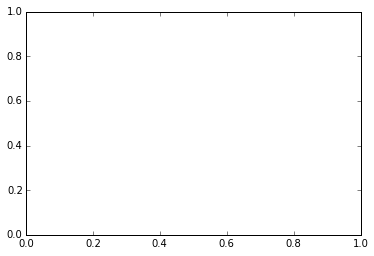

In [68]:
plt.figure()
plt.plot(xx, yy, 'bo-')
plt.xlabel('Intervalo')
plt.ylabel('Acurácia')
plt.show()

In [ ]:
def iterate_Testing_instances(path, keywords, negative_window,files_test):
    """
    Return an iterator over tuples containing:
    (concatenated tweet text, label, username)
    For each user in path, we find the first tweet containing one of the specified keywords.
    We then create one positive instance, containing all tweets prior to the matched tweet.
    We also create one negative instance, which is the same as the positive instance, except
    the N most recent tweets are removed (where N is set by the negative_window parameter).
    We additionally filter users if they use one of the keywords in one of their first `negative_window`
    tweets. This is to we have enough tweets to make a negative example.
    """ 
    for fname in files_test:#glob.glob(path + '/*.txt'):
        user = filename2user(fname)
        
        lines = []
        var=None
        tweetlist=[]
        count=0
        for i, line in enumerate(open(path+fname)):
            js = json.loads(line)
            # exclude people who use keyword within first `window` of tweets.
            if i <= negative_window and matches_keywords(js['text'], keywords):
                #print('skipping', fname, 'because uses keyword in first', negative_window, 'tweets')
                break
            if i > negative_window and matches_keywords(js['text'], keywords):
                print(user)
                var=''
                mylines = lines[-100:]
                #for li, l in enumerate(lines[-100:][::-1]):  # just look at the most recent 50 tweets.
                for li, l in enumerate(mylines):
                    var = var + ' ' + l
                    # yield(var,user)
                    # yield(l,user)
                    yield (' '.join(mylines[max(0, li-10):li]), user)
                    count=count+1
                    if count==1500:
                        break
                #tweetlist=[]
                var=None
                break
            lines.append(js['text'])
            
y_test = []
users_test = []
negative_window = 10
# The loop below iterates over each instance and vectorizes the text.
# Simulataneously, we append to the y (labels) and users lists.
# We do this to avoid having to store all the text in memory at once and to 
# only require one loop through the files.
files_test=[]
for _, _, arquivos in os.walk(DIR + '/Timeline/'): arquivos#list of all files in the directory
for f in arquivos:
    if f not in set(files_train):
        files_test.append(f)

print(len(arquivos))
print(len(set(files_test)))
print(len(files_train))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window, files_test)
X_ = vectorizer.transform(x[0] for x in iterator1 if not users_test.append(x[1]))
print('read %d instances into X matrix with shape %s' % (len(users_test), str(X_.shape)))
#print('label distribution=', Counter(y))
#y = np.array(y)
#users = np.array(users)
#print(type(y))
iterator1 = iterate_Testing_instances(DIR + '/Timeline/', keywords, negative_window,files_test)
iter1=list(iterator1)

In [ ]:
pred=model_mod.predict_proba(X_)

In [ ]:
X_.shape

In [ ]:
count =0
dictv = defaultdict(list)
for o in zip(iter1,pred):
    #print(o[0][1])
    dictv[o[0][1]].append(o[1][1])
print(len(dictv))

In [ ]:
%pylab inline
def is_interesting(vals):
    # if there's a significant jump between adjacent cells.
    for vi, vj in zip(vals[:-1], vals[1:]):
        if abs(vj - vi) > .00:
            return True
    return False

fig = plt.figure(figsize=(40,10))
for k,v in dictv.items():
    if is_interesting(dictv[k]):
        plt.plot(dictv[k])
print(len(dictv))

In [ ]:
import pickle 

output = open('predmodel.pkl', 'wb')
pickle.dump(pred, output)


In [ ]:
def plot_probs(dictv):
    %pylab inline
    fig = plt.figure(figsize=(40,10))
    
    for k, v in dictv.items():
        if is_interesting(v):
            i=1
            y=[]
            x=[]
            t = 1/len(dictv[k])
            for g in dictv[k]:
                y.append(g)
                x.append(i*t)
                i = i+1
            plt.xlabel('% of total tweets')
            plt.ylabel('Probability')
            plt.plot(x,y)

In [ ]:
plot_probs(dictv)

TypeError: 'module' object is not callable

In [93]:
from sklearn.feature_extraction import text
my_words = set(['my_stop_word_1','my_stop_word_2','hi','para','de','kkk'])
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)
vectorizer = text.TfidfVectorizer(stop_words=set(my_stop_words),max_features=15000)
XX = vectorizer.fit_transform(["Hi, this is a test string my_stop_word_2 Hi kkk my_stop_word agora para de um"])
vectorizer.get_feature_names()
#[u'hi', u'my_stop_word', u'string', u'test']

['agora', 'my_stop_word', 'string', 'test', 'um']